# Tutorial 3 : Attentive (Conditional) Neural Processes - 1D GP Data

Last Update : 22 June 2019

**Aim**: 
- Training a simple [Attentive Neural Process] (ANP) attention but less parameters.
- See how well a ANP "learns" a GP kernel

**Nota Bene:**
- Much more details about the framework and dataset can be found in [Tutorial 1 - Conditional Neural Process].
- Not much hyperparameter optimization done
- Architecture differs slightly from the paper to be more general and modularizable for future work.

[Attentive Neural Process]: https://arxiv.org/abs/1901.05761
[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

**Environment Hypermarameters:**

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/master


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

The dataset we will be using are simple functions sampled from different Gaussian kernel. See [Tutorial 1 - Conditional Neural Process] for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [4]:
from utils.visualize import plot_posterior_samples, plot_prior_samples, plot_dataset_samples
from ntbks_helpers import get_gp_datasets # defined in first tutorial (CNP)

X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
N_POINTS = 128
N_SAMPLES = 100000 # this is a lot and can work with less
datasets = get_gp_datasets(n_samples=N_SAMPLES, n_points=N_POINTS)

## Model

The general model architecture is slightly different from the paper to make it modular and easy to extend, but it is easy to make them equivalent with the right parameters. Refer to [Tutorial 1 - Conditional Neural Process] for an overview main parameters or the docstrings of `NeuralProcess` for all parameters. 

Differences with [Tutorial 1 - Conditional Neural Process]:
- `AttentiveNeuralProcess` and `attention="transformer"` to use a cross attention as in [Image Transformer]. To replicate the paper you should use `attention="multihead"` (less parameters but converges a bit slower).
- `encoded_path="deterministic"` to use only a deterministic path. To replicate the paper you should use `encoded_path="both"`, thus also using a latent path. In this series of notebooks, I am using kernel with fix hyperparameters which doesn't require any latent path (which they say in the paper and I have seen in practice).
- `r_dim=64` to use smaller representations, because the model is very expressive while the task is relatively simple (`r_dim=128` in the paper).

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb
[Image Transformer]: https://arxiv.org/abs/1802.05751

In [5]:
from neuralproc import AttentiveNeuralProcess
from ntbks_helpers import CNP_KWARGS # defined in first tutorial (CNP)

ANP_KWARGS = CNP_KWARGS.copy()
ANP_KWARGS["encoded_path"] = "deterministic" 
ANP_KWARGS["attention"] = "transformer"
ANP_KWARGS["r_dim"] = 64

# initialize one model for each dataset
data_models = {name: (AttentiveNeuralProcess(X_DIM, Y_DIM, **ANP_KWARGS), data) 
                   for name, data in datasets.items()}

/master/neuralproc/utils/torchextend.py:53: UserWarning: hidden_size=32 smaller than output=64 and input=64. Setting it to 64.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


### N Param

Number of parameters (note that I did not play around with this much, this depends a lot on the representation size):

In [6]:
from utils.helpers import count_parameters

In [7]:
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break

N Param: 51330


Using `"transformer"` attention increases the number of parameters, but using a deterministic path as well a smaller representation seize decreases the number of parameters.

## Training

In [8]:
from ntbks_helpers import train_all_models_

train_all_models_(data_models, "results/notebooks/neural_process/small_anp",
                  is_retrain=False) # if false load precomputed


--- Loading rbf ---


--- Loading periodic ---


--- Loading matern ---


--- Loading noisy-matern ---



The model converges extremely quickly ($\sim 15$ epochs)  but already has very good predictions after $\sim 5$ epochs.

# Inference

## Trained Prior

In [9]:
EXTRAP_DISTANCE = 1.5  # add 1.5 to the right for extrapolation
INTERPOLATION_RANGE = dataset.min_max
EXTRAPOLATION_RANGE = (dataset.min_max[0], dataset.min_max[1]+EXTRAP_DISTANCE )

std: 0.3382172293961047
std: 0.4565397815406323
std: 0.4519845291972161
std: 0.5110787951946258


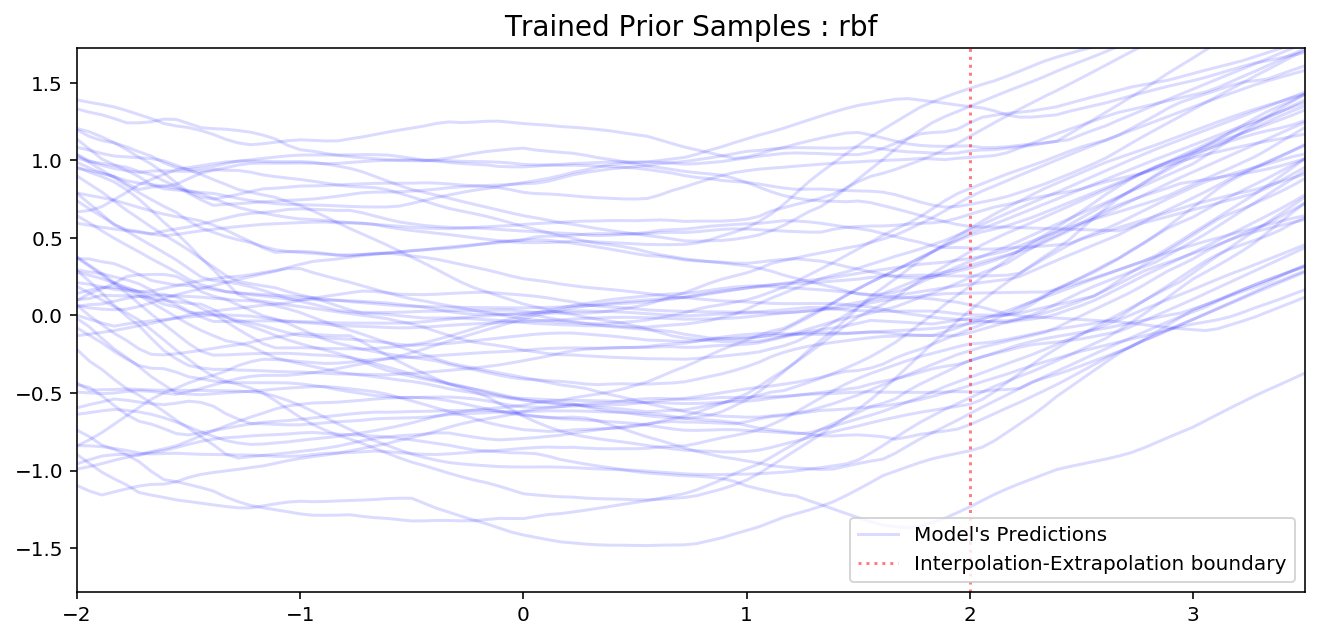

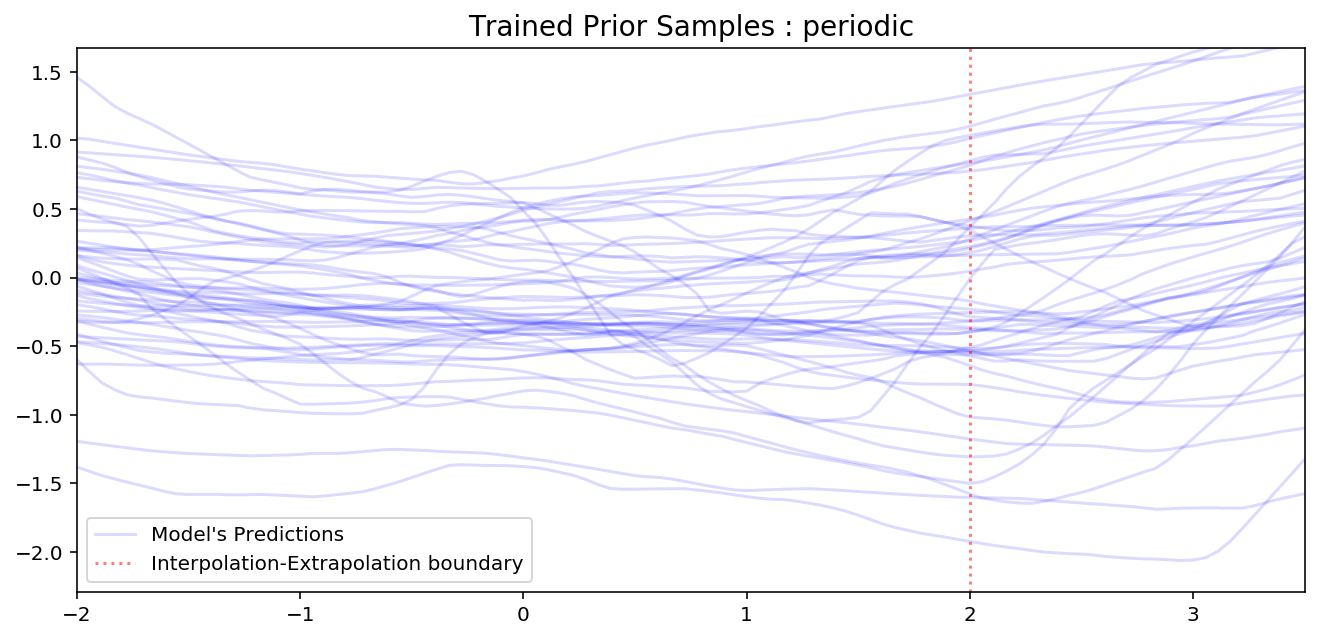

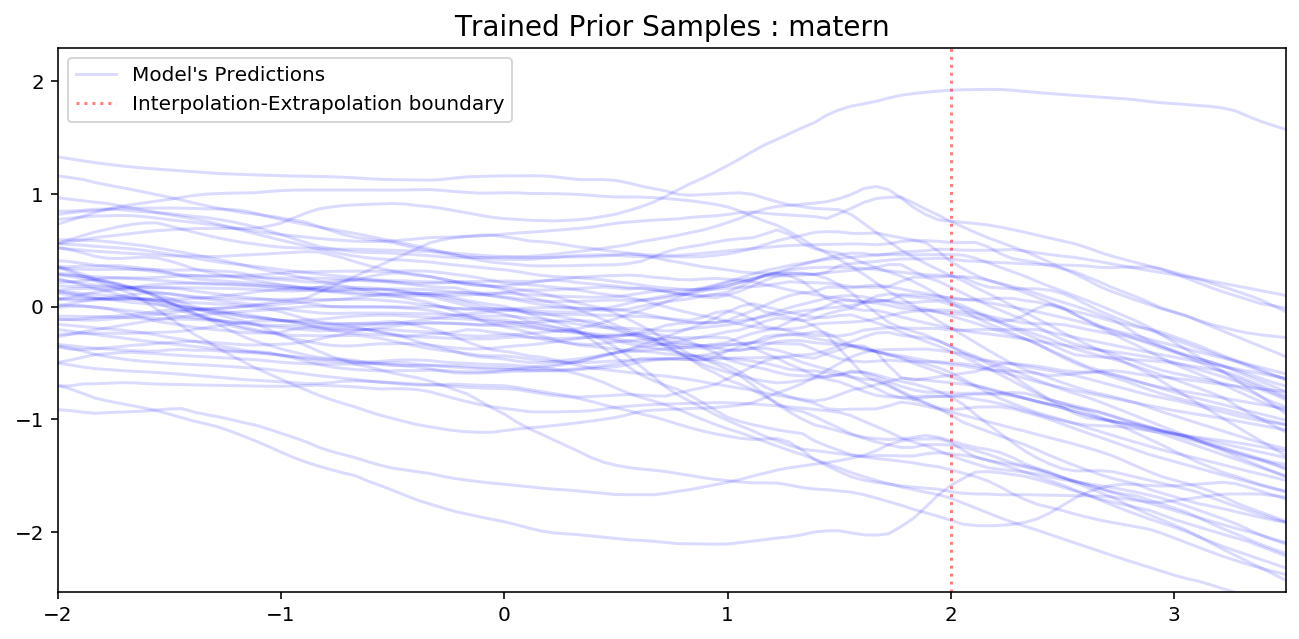

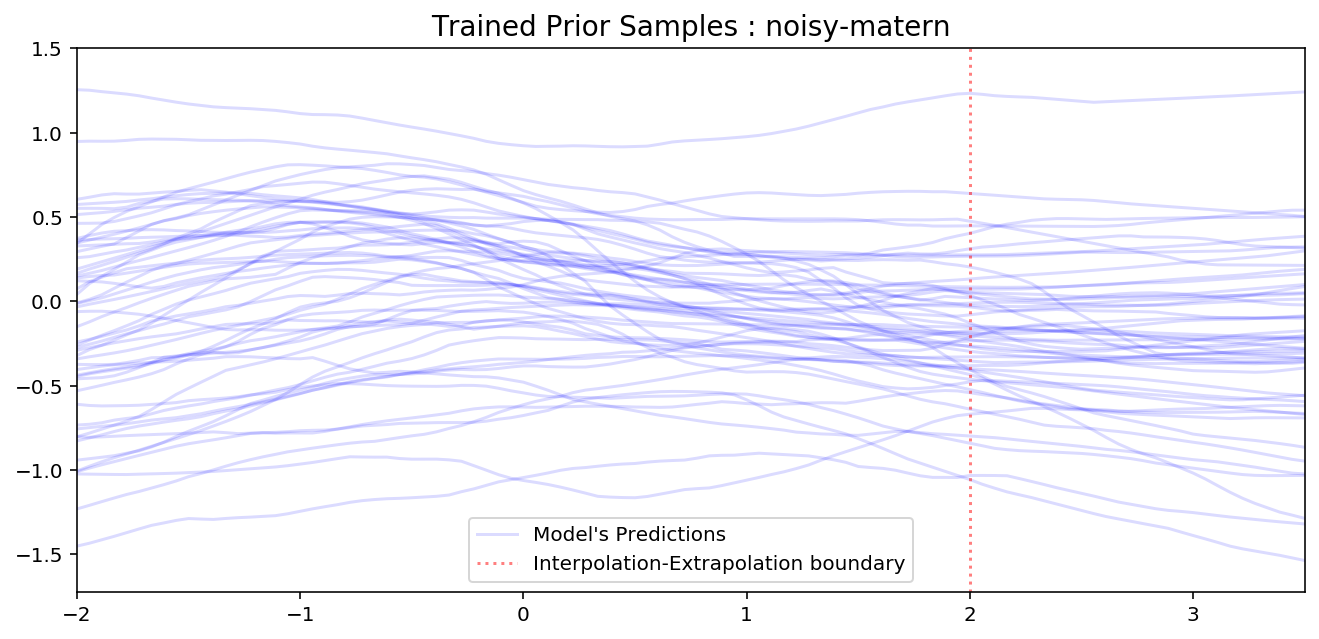

In [10]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, 
                       title="Trained Prior Samples : {}".format(k), 
                       test_min_max=EXTRAPOLATION_RANGE, 
                       train_min_max=INTERPOLATION_RANGE)

# Posterior

std: 0.5628644824028015
std: 0.9473804831504822
std: 0.5103864073753357
std: 0.9434208869934082


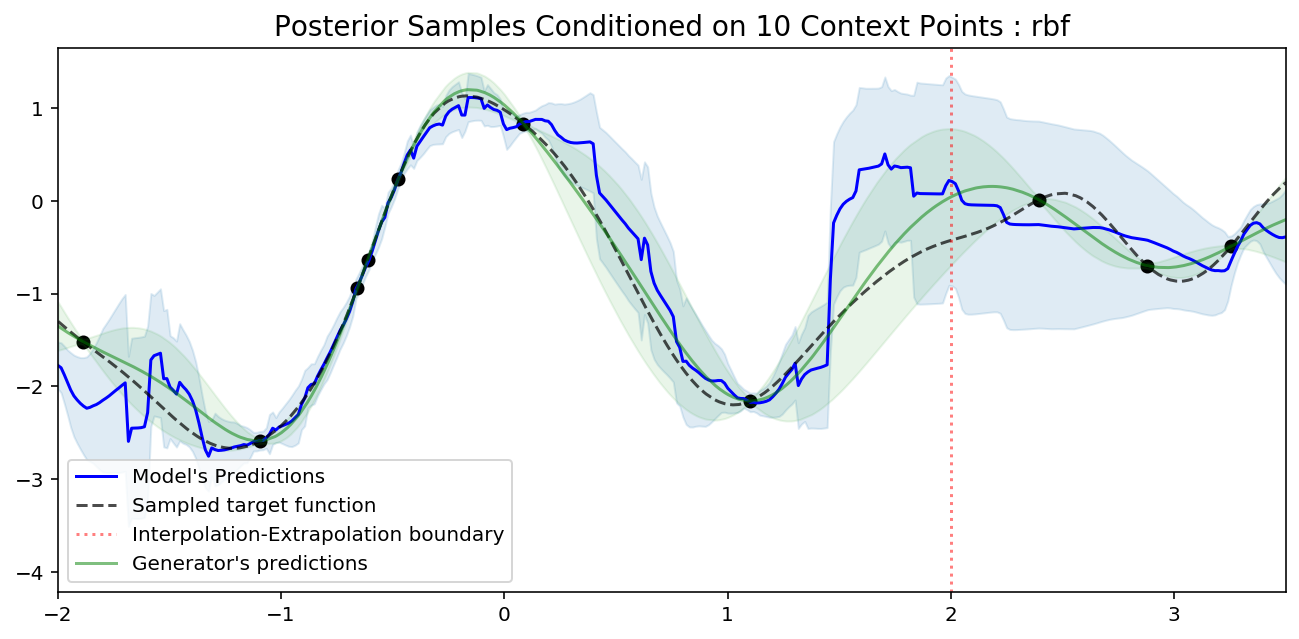

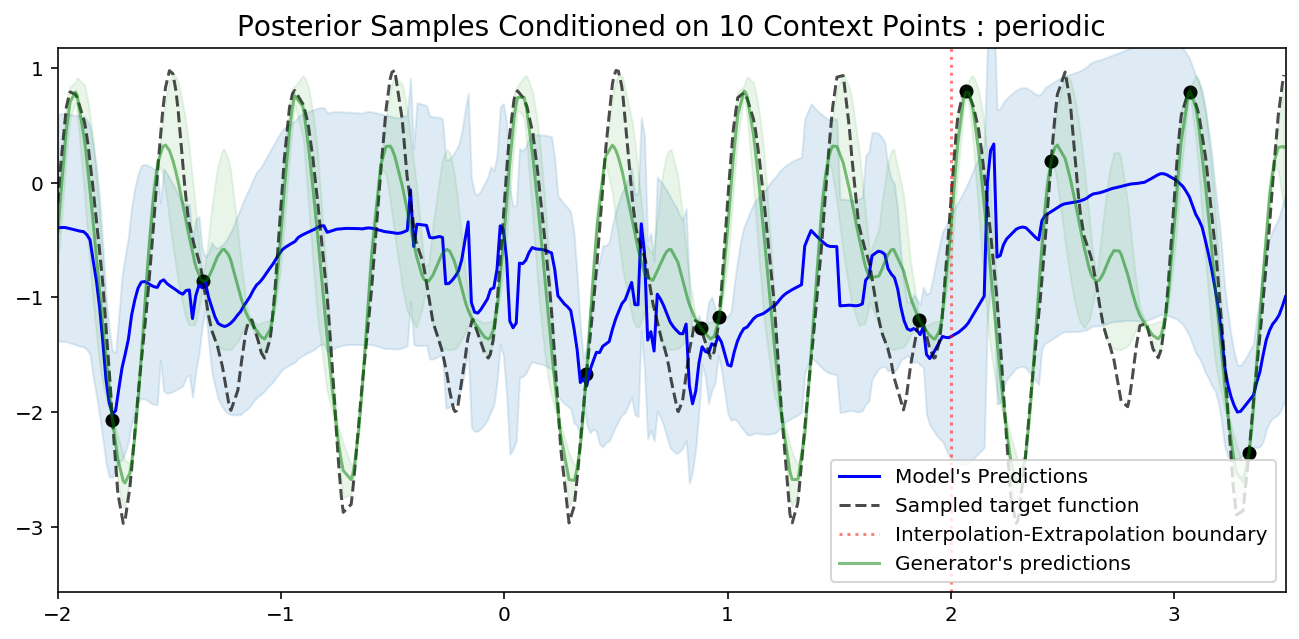

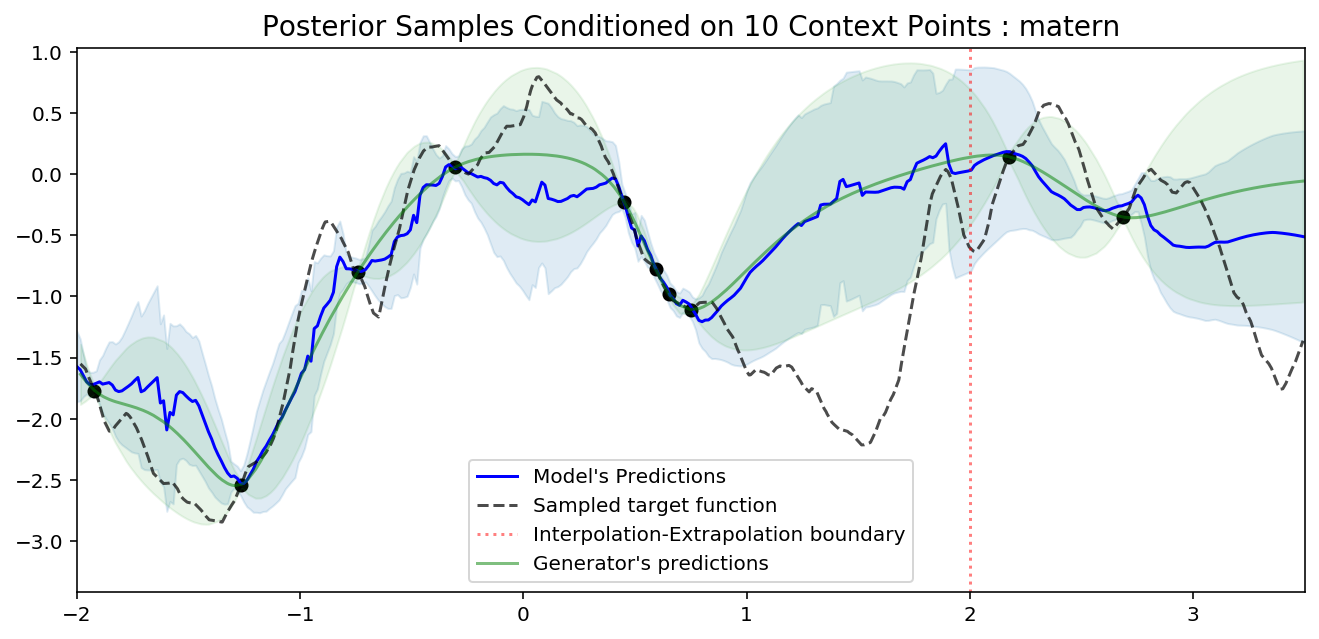

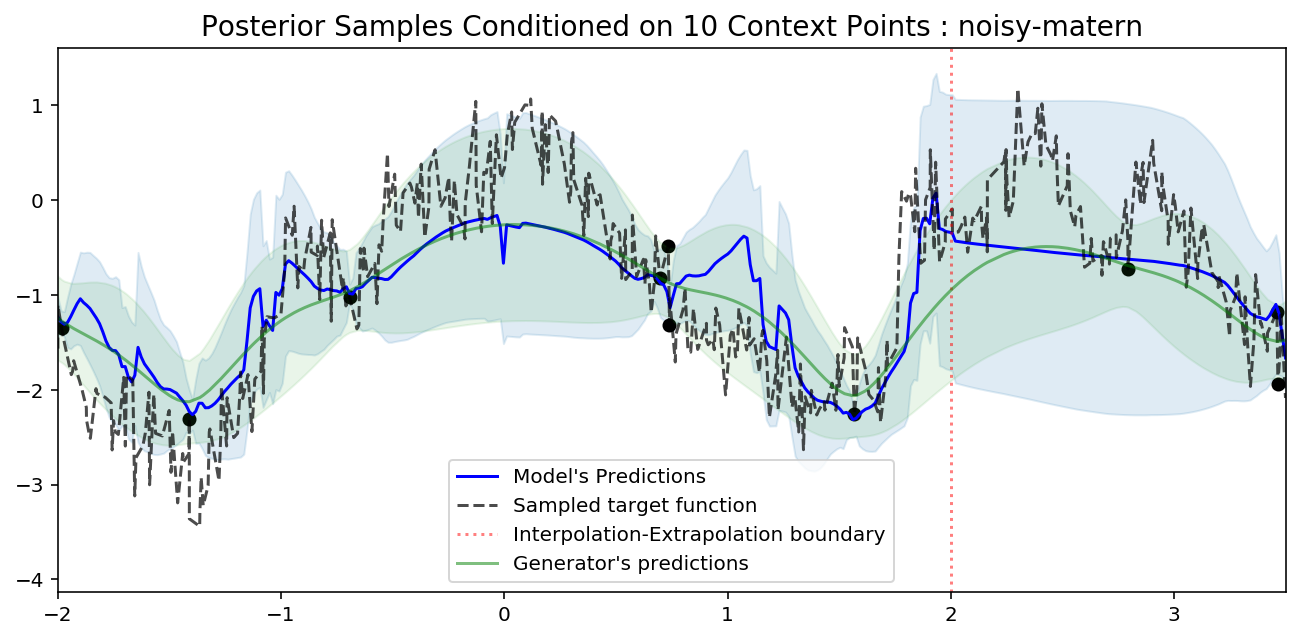

In [11]:
N_CNTXT = 10
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=3*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

std: 0.8572710752487183
std: 0.9272124171257019
std: 0.7384293675422668
std: 1.1260409355163574


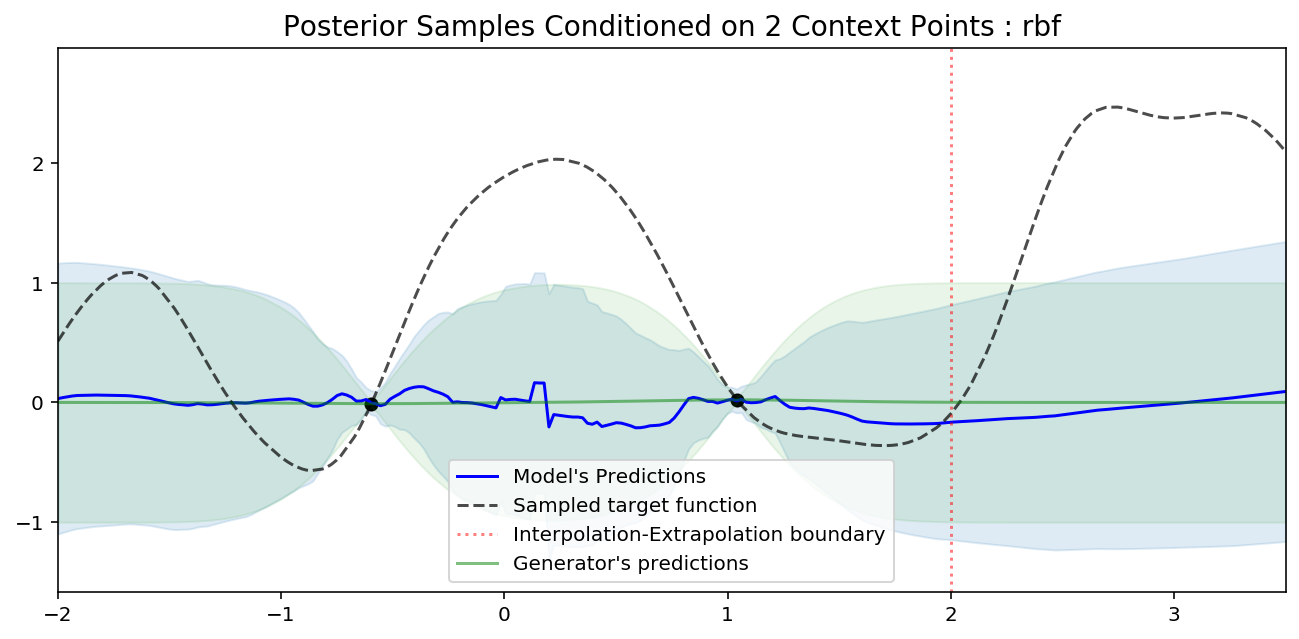

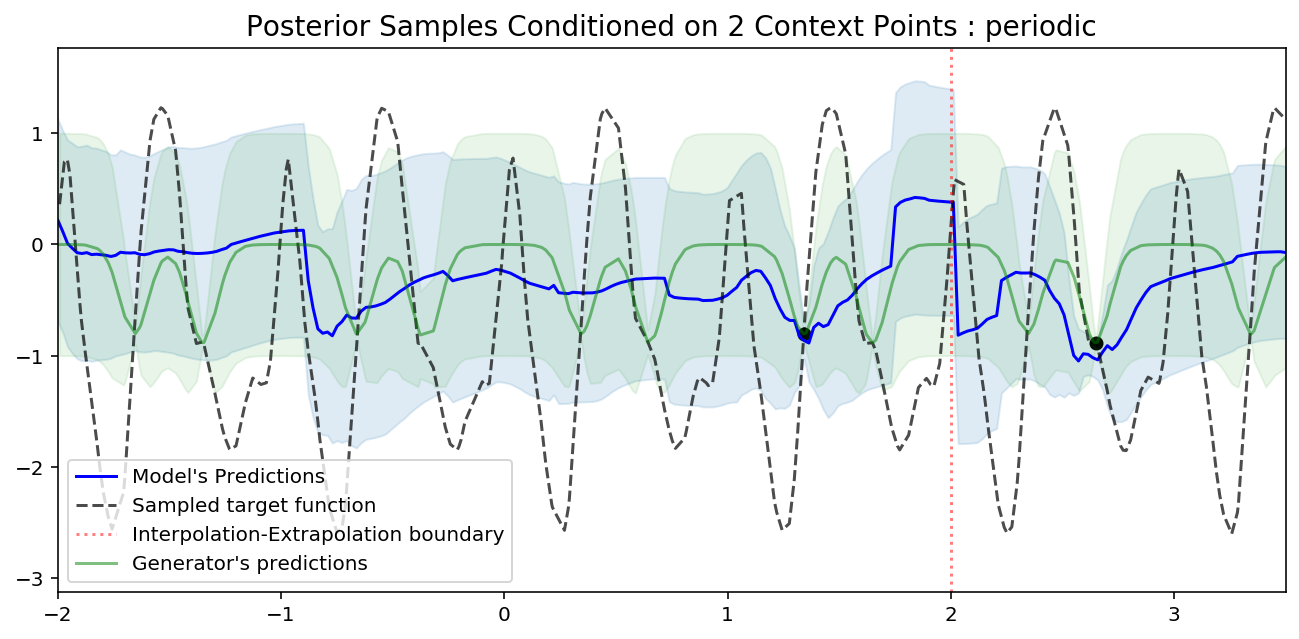

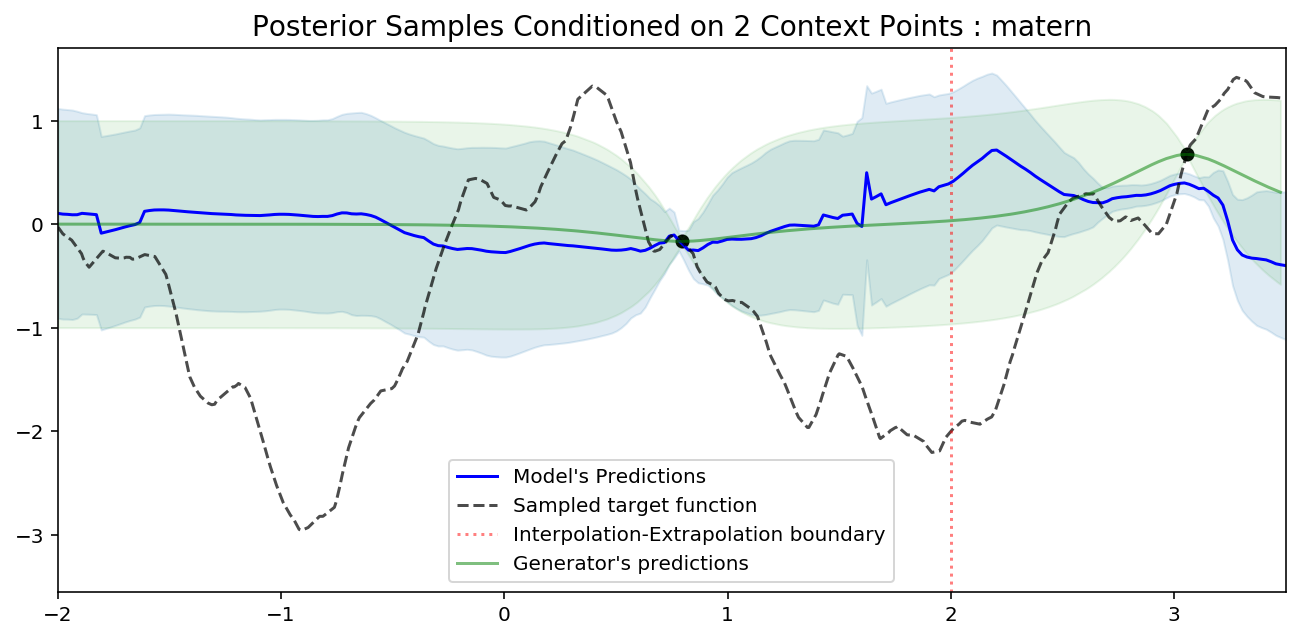

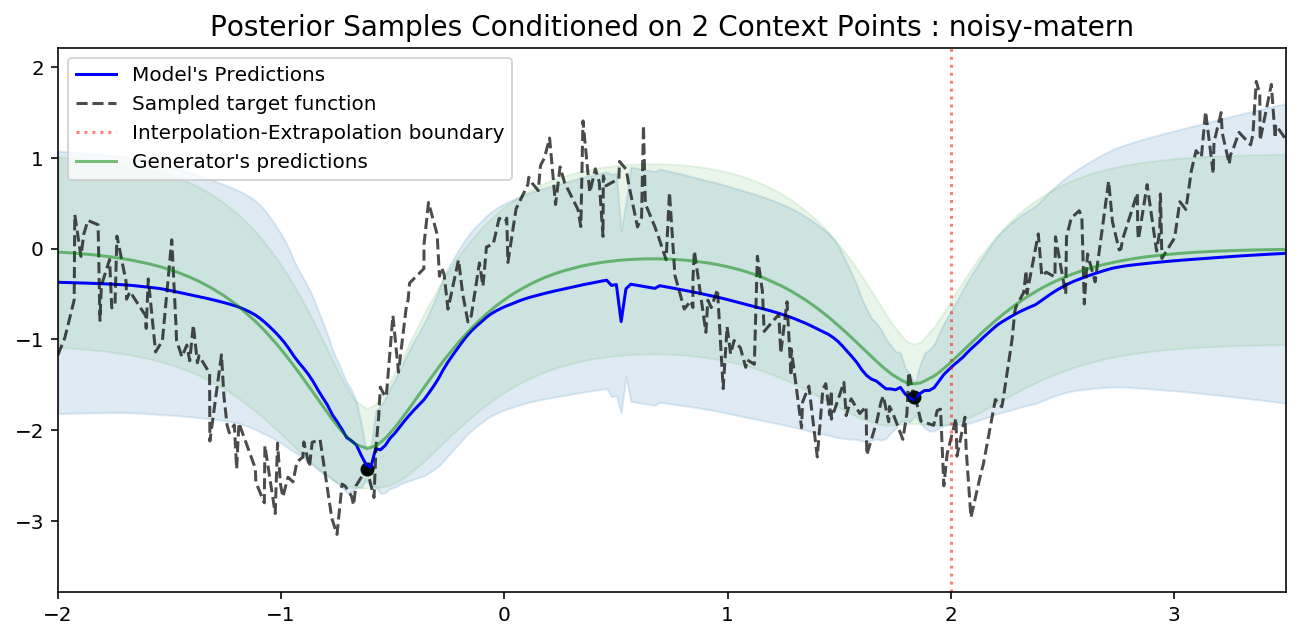

In [12]:
N_CNTXT = 2
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

std: 0.49005526304244995
std: 0.9278817176818848
std: 0.37729018926620483
std: 0.7682821750640869


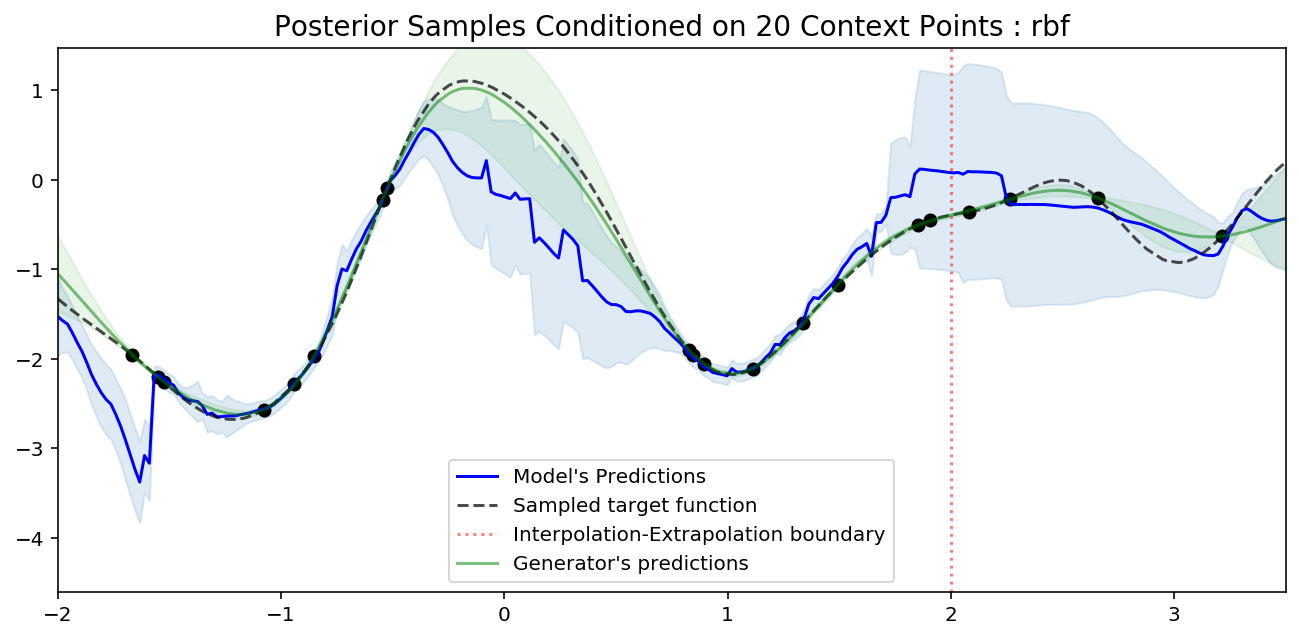

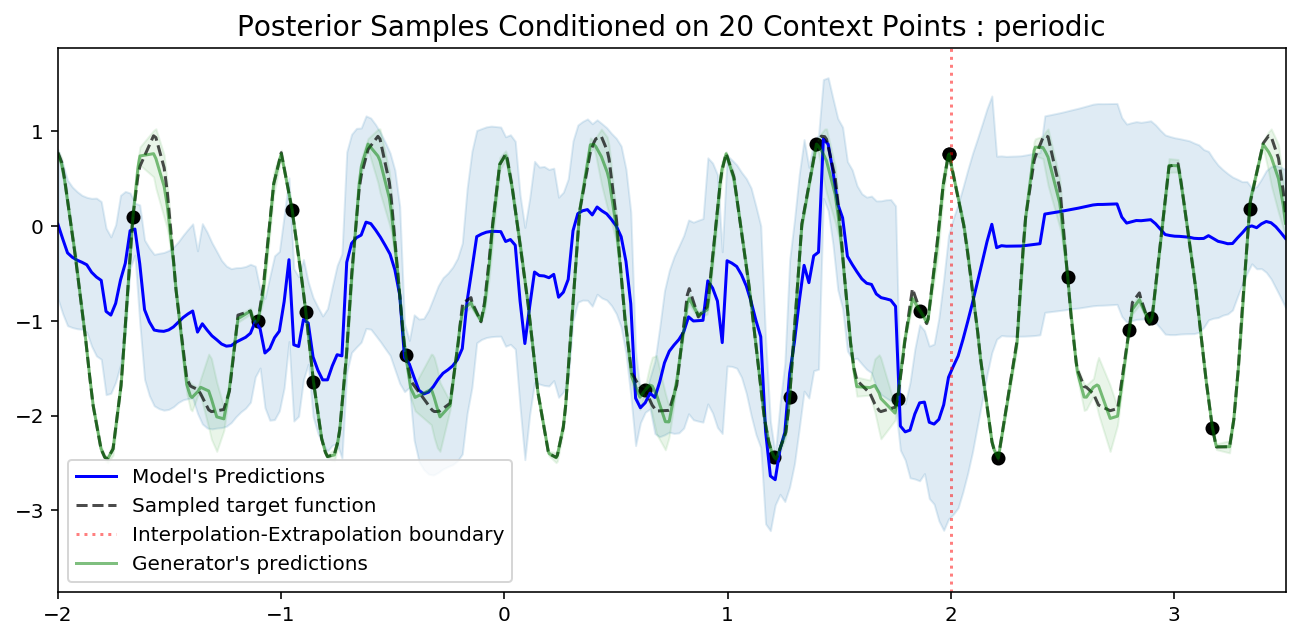

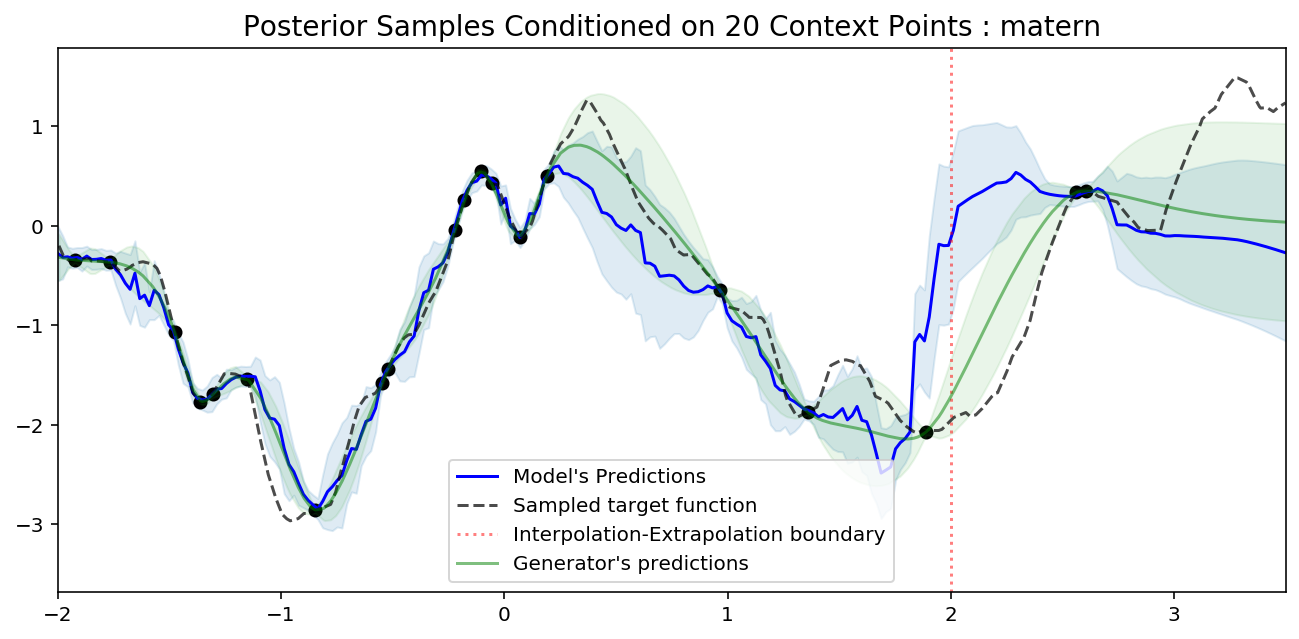

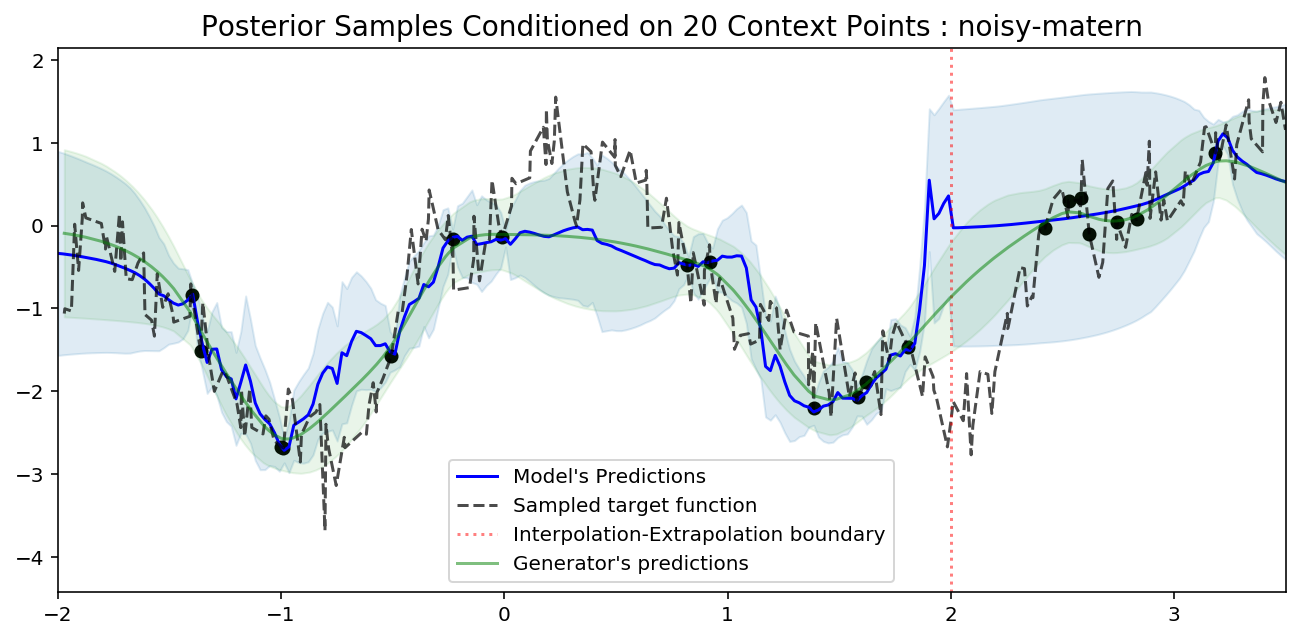

In [13]:
N_CNTXT = 20
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

std: 1.0402995347976685
std: 0.9348608255386353
std: 0.9569544792175293
std: 1.2879993915557861


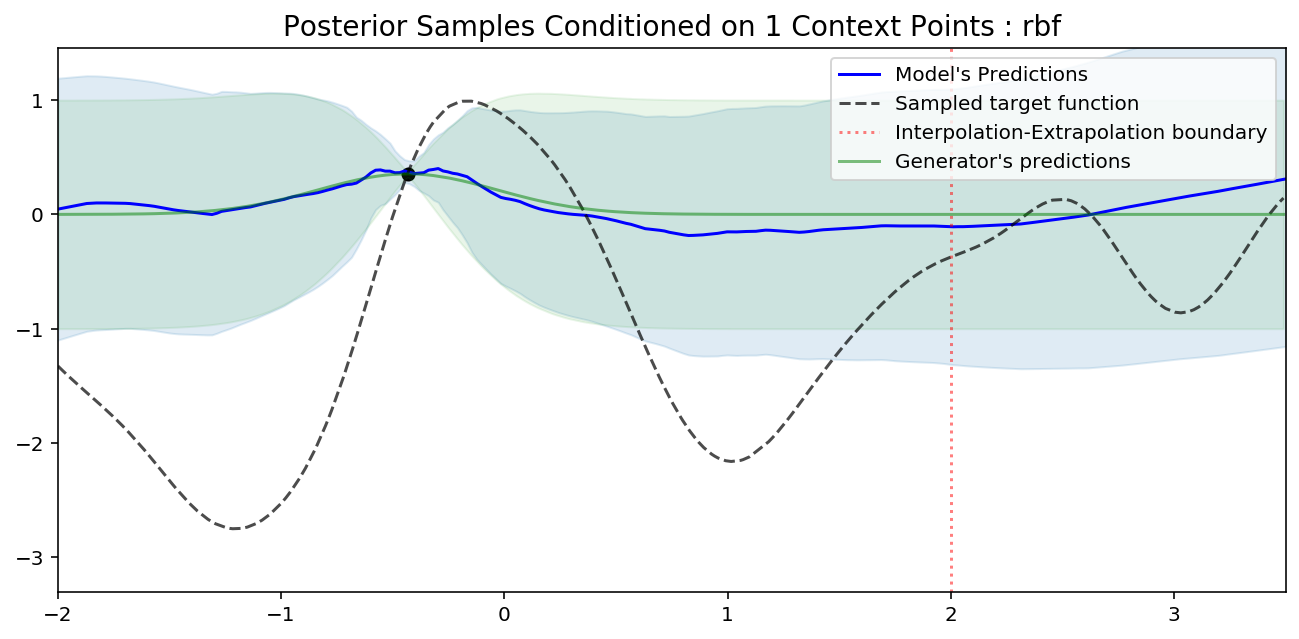

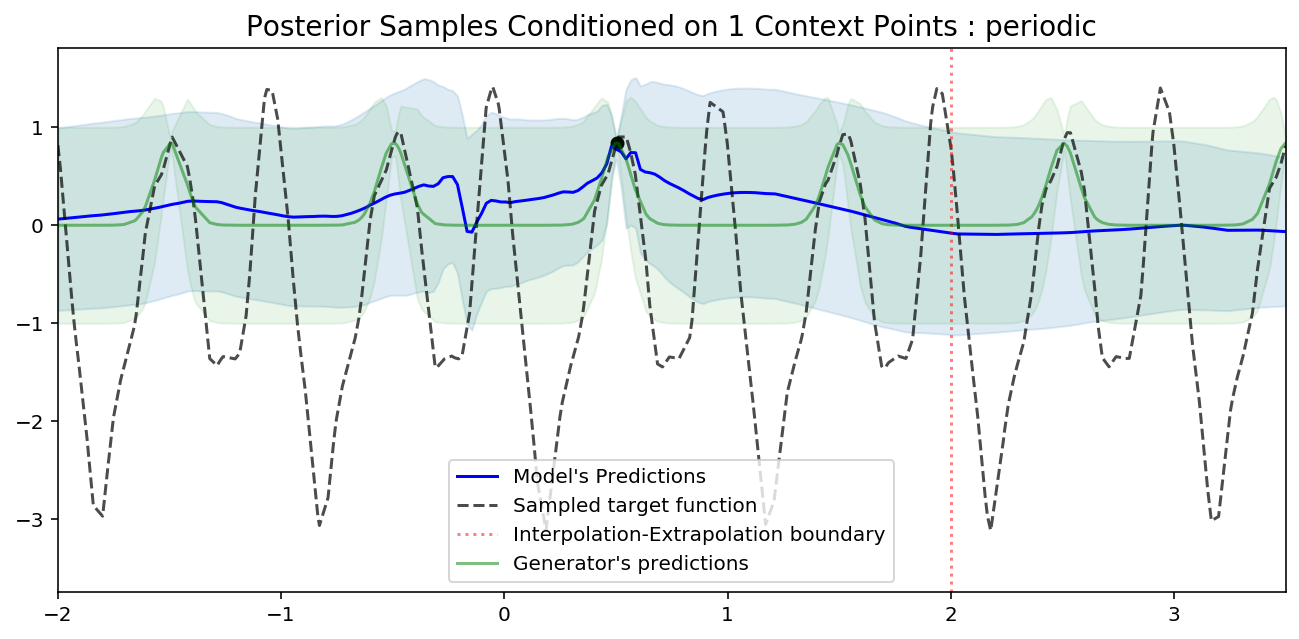

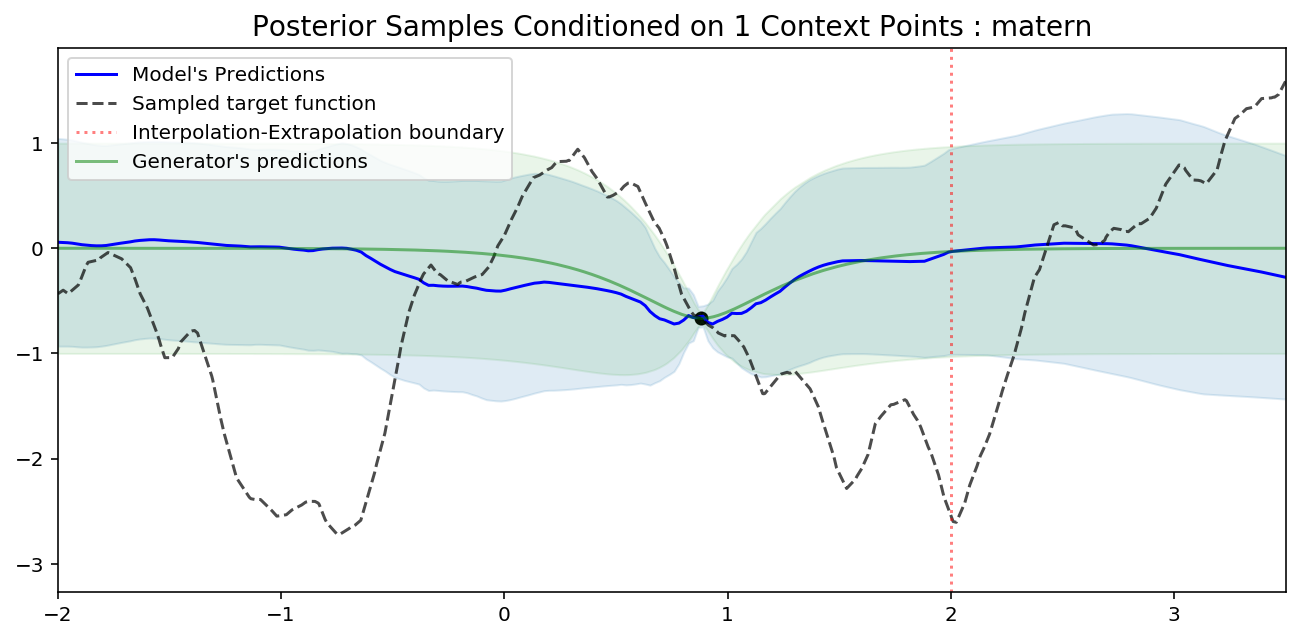

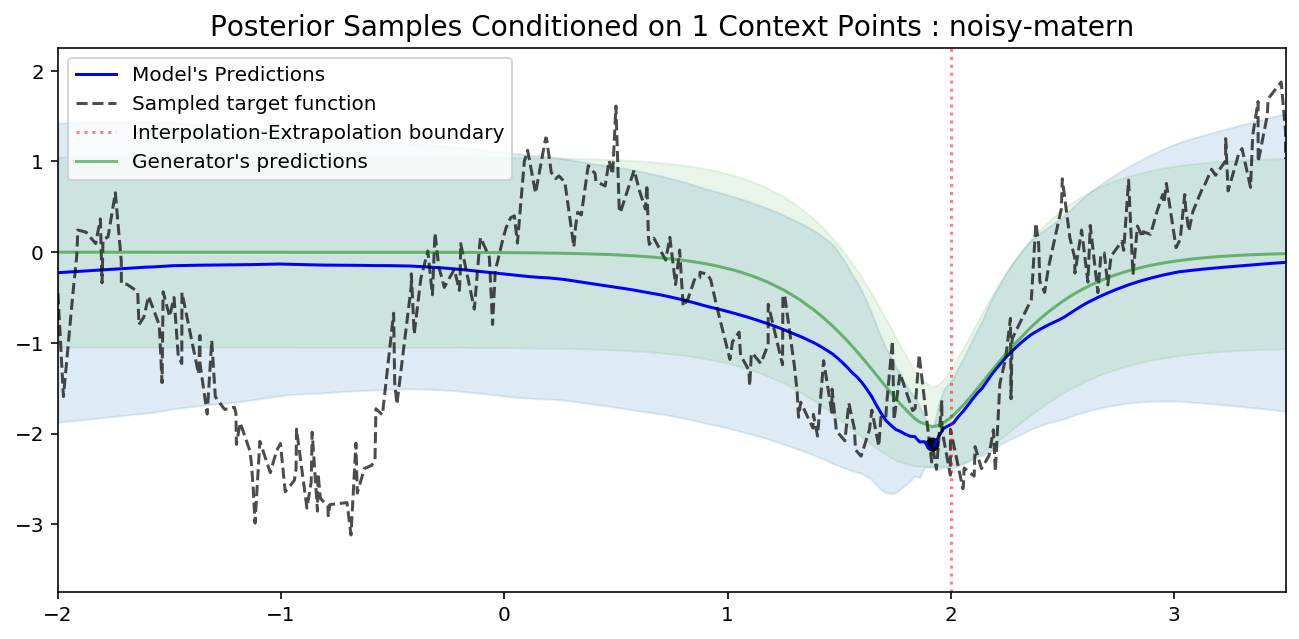

In [14]:
N_CNTXT = 1
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

We see that the predictions are much better than in [Tutorial 2 - Neural Process]

**Good**:
- often close to GP with the correct kernel
- the uncertainty decreases close to context points
- no more underfitting : the sampled function all go through or close to the context points
- does all of this with "only" 50k param (and I did not try to go below).
- very good results after $\sim 5$ epochs

**Bad**:
- there seems be some strange "jumps" in regions far from points. This is probably due to the softmax in cross attention, indicating that a head attends to a new point. This makes the model less smooth than GP, but could probably be solved using self attention or a larger model. 
- cannot extrapolate
- still not as smooth as GP
- not good at periodicity

[Tutorial 2 - Neural Process]: Tutorial%202%20-%20Neural%20Process.ipynb